### Evaluating the FoldSeek results
1. Extract MSA information from files
2. Extract pLDDT information from files
3. Interpreting and plotting the pLDDTs and MSA depths

In [2]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
# created-by: conda 24.11.0
@EXPLICIT
https://repo.anaconda.com/pkgs/main/linux-64/_libgcc_mutex-0.1-main.conda
https://repo.anaconda.com/pkgs/main/linux-64/ca-certificates-2024.11.26-h06a4308_0.conda
https://repo.anaconda.com/pkgs/main/linux-64/ld_impl_linux-64-2.38-h1181459_1.conda
https://repo.anaconda.com/pkgs/main/linux-64/libstdcxx-ng-11.2.0-h1234567_1.conda
https://repo.anaconda.com/pkgs/main/noarch/pybind11-abi-5-hd3eb1b0_0.conda
https://repo.anaconda.com/pkgs/main/noarch/tzdata-2024a-h04d1e81_0.conda
https://repo.anaconda.com/pkgs/main/linux-64/libgomp-11.2.0-h1234567_1.conda
https://repo.anaconda.com/pkgs/main/linux-64/_openmp_mutex-5.1-1_gnu.conda
https://repo.anaconda.com/pkgs/main/linux-64/libgcc-ng-11.2.0-h1234567_1.conda
https://repo.anaconda.com/pkgs/main/linux-64/bzip2-1.0.8-h5eee18b_6.conda
https://repo.anaconda.com/pkgs/main/linux-64/c-ares-1.

In [3]:
# imports
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Bio
import seaborn as sns
from Bio.PDB import *

### Goal 1: extract MSA information from files

AlphaFold builds protein structure models based on information extracted from MSAs. Hence, the depth of the MSA is one of the metrics to take into account when looking at the overall quality of the protein prediction. 

To get this information, we will have to loop over the batches, then go into the info file for each protein result, and extract this info from the line 'Sequence coverage'.

In [7]:
def extract_msa_depth(logfile):
    with open(logfile) as infile:
        # Read file and extract lines on MSA depth
        lines = infile.read().splitlines()
        start_i = None  # Initialize start index
        
        for i, line in enumerate(lines):
            if "Sequence coverage:" in line:
                start_i = i
                break  # Stop at the first occurrence
        
        # Ensure start_i was found before proceeding
        if start_i is None:
            print(f"Warning: 'Sequence coverage' not found in {logfile}")
            return None, None
        
        # Extract sequence coverage values
        msa_depth_text = lines[start_i]
        msa_depth_per_pos = []
        
        # Modify string to have space around square brackets for easier digit extraction
        msa_depth_text = msa_depth_text.replace("[", "[ ").replace("]", " ]")
        
        for word in msa_depth_text.split():
            if word.isdigit():
                msa_depth_per_pos.append(int(word))
        
        if not msa_depth_per_pos:
            print(f"Warning: No MSA depth values found in {logfile}")
            return None, None
        
        max_depth = max(msa_depth_per_pos)
        avg_depth = np.mean(msa_depth_per_pos)
        
        return max_depth, avg_depth

In [ ]:
base_path = "c_structure_annotation/structure_prediction"
# Dictionary to store results
protein_msadepth = {}

# Looping over batches
for i in range(3):  # Iterating over batch_0, batch_1, batch_2
    batch = f"batch_{i}"
    path_results = os.path.join(base_path, batch, "results")

    
    # Iterate over all protein folders in the results directory
    for protein in os.listdir(path_results):
        protein_dir = os.path.join(path_results, protein)
        logfile = os.path.join(protein_dir, f"{protein}_info.log")  # Correct log file name format
        
        # Ensure logfile exists before attempting to read it
        if os.path.isfile(logfile):
            max_depth, avg_depth = extract_msa_depth(logfile)
            if max_depth is not None and avg_depth is not None:
                protein_msadepth[protein] = (max_depth, avg_depth)
        else:
            print(f"Log file missing for {protein} in {batch}")
    
    print(f"Finished {batch} MSA depth analysis.")


### Goal 2: extract pLDDT information from files

AlphaFold builds protein structure models which it also gives a per-residue accuracy score, the pLDDT. This pLDDT can be used as a quality metric, hence, let's investigate the pLDDT scores for all our proteins.

To get this information, we will have to loop over the batches, then open the PDB file of the best/relaxed structure and extract the pLDDT scores.

In [9]:
# define a PDB parser
p = PDBParser()

In [10]:
# function for calculating average pLDDT
    # as copied and adapted from "paper_acetyltransferases" Notebook "Code_search_structure_annotation_Linux.ipynb" 
def avg_pLDDT(structure):
    for model in structure:
        for chain in model:
            count_residue = 0
            pLDDT_chain = 0
            for residue in chain:
                count_residue += 1
                count_atom = 0
                pLDDT_atom = 0
                for atom in residue:
                    count_atom += 1
                    pLDDT_atom += atom.get_bfactor()
                pLDDT_res = pLDDT_atom/count_atom
                # pLDDT_res = round(pLDDT_atom/count_atom,2)
                pLDDT_chain += pLDDT_res
        pLDDT_avg = round(pLDDT_chain/count_residue,2)
    return pLDDT_avg

In [ ]:
base_path = "c_structure_annotation/structure_prediction"
# Dictionary to store results
protein_plddt = {}

# Looping over batches
for i in range(3):  # Iterating over batch_0 to batch_20
    batch = f"batch_{i}"
    path_results = os.path.join(base_path, batch, "results")

    # Iterate over all protein folders in the results directory
    for protein in os.listdir(path_results):
        protein_dir = os.path.join(path_results, protein)        
        # Extract pLDDT
        relaxed_pdb = os.path.join(protein_dir, f"{protein}_relaxed.pdb")
        structure = None
        
        if os.path.isfile(relaxed_pdb):
            structure = p.get_structure(protein, relaxed_pdb)
        else:
            for item in os.listdir(protein_dir):
                if "rank_1" in item and item.endswith(".pdb"):
                    structure = p.get_structure(protein, os.path.join(protein_dir, item))
                    break
        
        if structure:
            protein_plddt[protein] = avg_pLDDT(structure)
        else:
            print(f"No suitable PDB file found for {protein} in {batch}")
    
    print(f"Finished {batch} pLDDT analysis.")


### Goal 3: interpreting and plotting the pLDDTs and MSA depths

In [12]:
# the data for the MSA depth analysis
max_MSA_depth = [x[0] for x in protein_msadepth.values()]
avg_MSA_depth = [x[1] for x in protein_msadepth.values()]
data_MSAd = pd.DataFrame(data = {"protein" : protein_msadepth.keys(), "max MSA depth" : max_MSA_depth, "avg MSA depth" : avg_MSA_depth})

A common assessor for MSA depth is just the maximum depth over the entire protein, so let's check! As a rule of thumb, a cut off of 30 sequences in the MSA is suggested for good quality predictions, so let's look how often we match this bar. 

In [13]:
avg_max = round(np.mean(max_MSA_depth))
med_max = np.median(max_MSA_depth)
min30_num = len(data_MSAd[data_MSAd["max MSA depth"] >= 30])
num_proteins = len(max_MSA_depth)
pct_ok = round(min30_num/num_proteins*100, 2)
print(f"On average, the maximal MSA depth used for structure prediction for our {num_proteins} proteins is {avg_max} sequences (median: {med_max}).")
print(f"The maximal MSA depth used for structure prediction for {min30_num} out of our {num_proteins} proteins ({pct_ok}%) is above 30 sequences, which is used as a general rule of thumb.")

On average, the maximal MSA depth used for structure prediction for our 1226 proteins is 265 sequences (median: 28.0).
The maximal MSA depth used for structure prediction for 609 out of our 1226 proteins (49.67%) is above 30 sequences, which is used as a general rule of thumb.


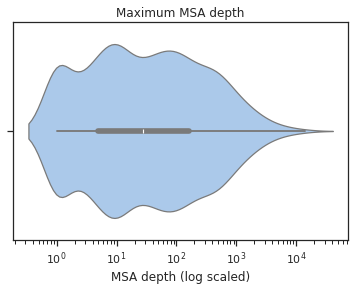

In [14]:
sns.set(style="ticks", palette="pastel")
maxF = sns.violinplot(x=data_MSAd["max MSA depth"], log_scale=True)
maxF.set(title = "Maximum MSA depth", xlabel = "MSA depth (log scaled)")
plt.show()

In [15]:
# however, averages can hide quite large discrepencies over entire proteins, so let's look at the average MSA depth as well
avg_avg = round(np.mean(avg_MSA_depth))
med_avg = round(np.median(avg_MSA_depth))
min30avg_num = len(data_MSAd[data_MSAd["avg MSA depth"] >= 30])
pct_ok_avg = round(min30avg_num/num_proteins*100, 2)
print(f"On average, the average MSA depth used for structure prediction for our {num_proteins} proteins is {avg_avg} sequences (median: {med_avg}).")
print(f"The average MSA depth used for structure prediction for {min30avg_num} out of our {num_proteins} proteins ({pct_ok_avg}%) is above 30 sequences, which is used as a general rule of thumb.")

On average, the average MSA depth used for structure prediction for our 1226 proteins is 200 sequences (median: 21).
The average MSA depth used for structure prediction for 554 out of our 1226 proteins (45.19%) is above 30 sequences, which is used as a general rule of thumb.


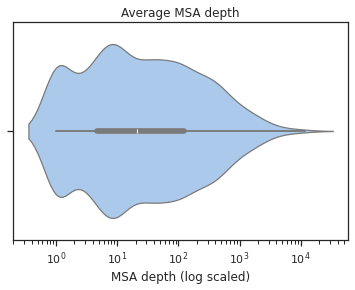

In [16]:
avgF = sns.violinplot(x=data_MSAd["avg MSA depth"], log_scale=True)
avgF.set(title = "Average MSA depth", xlabel = "MSA depth (log scaled)")
plt.show()

While the MSA depth is correlated to the quality, the actual quality metric for AlphaFold predictions lies in the pLDDT, so let's look at that. 

In [17]:
# the data for pLDDT analysis
data_plddt = pd.DataFrame(data = protein_plddt.items(), columns = ["protein", "avg pLDDT"])

In [18]:
avg_plddt = round(np.mean(data_plddt["avg pLDDT"]),2)
med_plddt = np.median(data_plddt["avg pLDDT"])
min70_num = len(data_plddt[data_plddt["avg pLDDT"] >= 70])
pct_ok_plddt = round(min70_num/num_proteins*100, 2)
print(f"On average, the pLDDT score for structures predicted for our {num_proteins} proteins is {avg_plddt} (median: {med_plddt}).")
print(f"The pLDDT score for structures predicted for {min70_num} out of our {num_proteins} proteins ({pct_ok_plddt}%) is at least 70, which is used as a general cut-off for trustworthy structure predictions.")

On average, the pLDDT score for structures predicted for our 1226 proteins is 76.97 (median: 80.225).
The pLDDT score for structures predicted for 874 out of our 1226 proteins (71.29%) is at least 70, which is used as a general cut-off for trustworthy structure predictions.


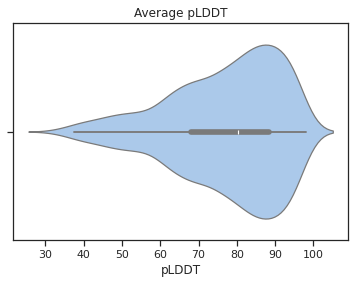

In [19]:
plddtF = sns.violinplot(x=data_plddt["avg pLDDT"])
plddtF.set(title = "Average pLDDT", xlabel = "pLDDT")
plt.show()

correlation between those two: we expect there to be better pLDDT for proteins with deeper MSAs, and especially poor pLDDTs for proteins with shallow MSAs which have less than 30 sequences.

In [20]:
# creating combined dataframe
plddt_MSA_df = data_MSAd.merge(data_plddt)

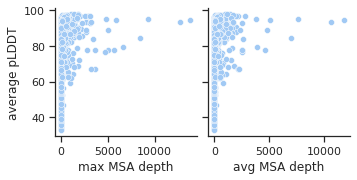

In [21]:
# plotting with pairplot
corrF = sns.pairplot(plddt_MSA_df, 
                 x_vars=["max MSA depth", "avg MSA depth"],
                 y_vars=["avg pLDDT"])
corrF.set(ylabel = "average pLDDT")
plt.show()

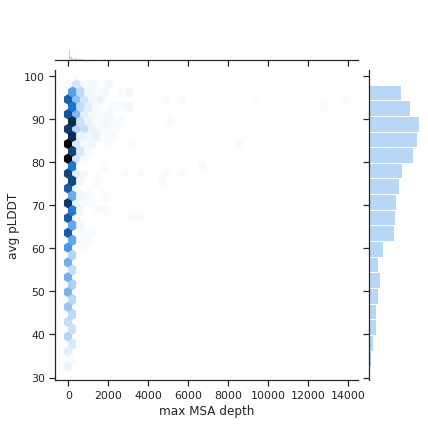

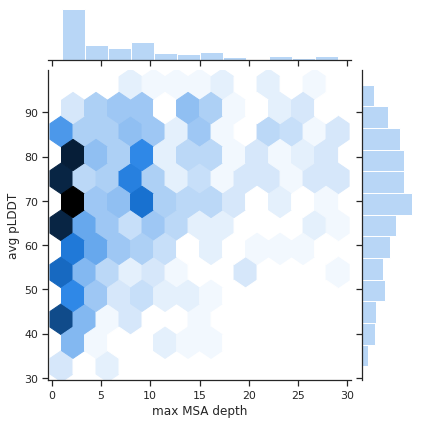

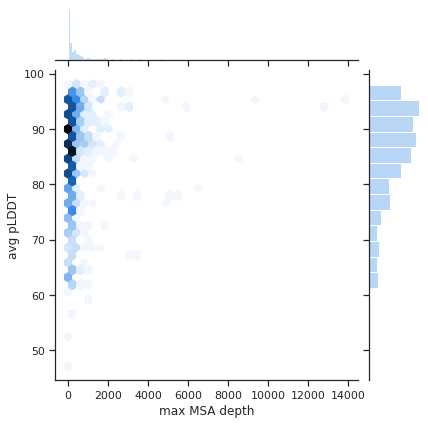

In [23]:
# plots for max MSA depth
    # very crowded at small MSA depth, so let's add subplots for that - by the 30 MSA depth cut off
maxF = sns.jointplot(plddt_MSA_df, x = "max MSA depth", y = "avg pLDDT", kind = "hex")
max_u30F = sns.jointplot(plddt_MSA_df[plddt_MSA_df["max MSA depth"] < 30], x = "max MSA depth", y = "avg pLDDT", kind = "hex")
max_a30F = sns.jointplot(plddt_MSA_df[plddt_MSA_df["max MSA depth"] >= 30], x = "max MSA depth", y = "avg pLDDT", kind = "hex")
plt.show()

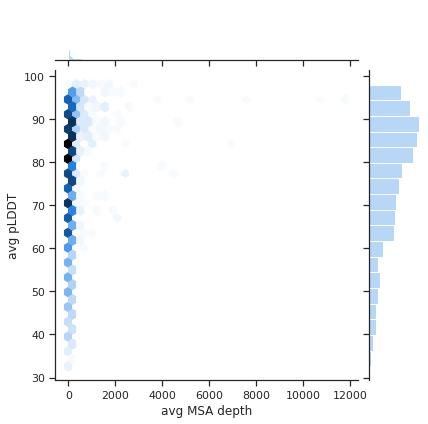

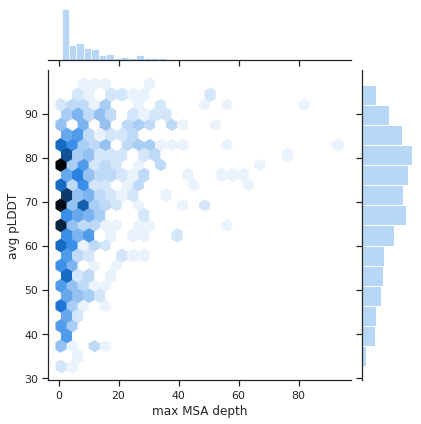

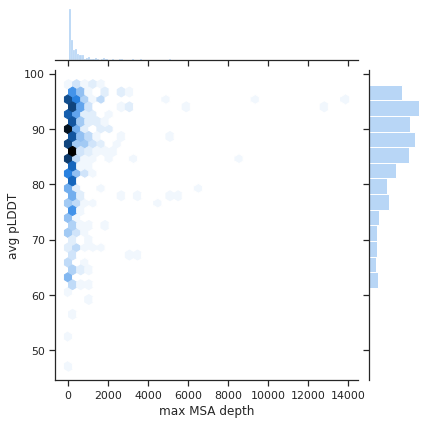

In [24]:
# plots for avg MSA depth
    # very crowded at small MSA depth, so let's add subplots for that - by the 30 MSA depth cut offmaxF = sns.jointplot(plddt_MSA_df, x = "max MSA depth", y = "avg pLDDT", kind = "hex")
avgF = sns.jointplot(plddt_MSA_df, x = "avg MSA depth", y = "avg pLDDT", kind = "hex")
avg_u30F = sns.jointplot(plddt_MSA_df[plddt_MSA_df["avg MSA depth"] < 30], x = "max MSA depth", y = "avg pLDDT", kind = "hex")
avg_a30F = sns.jointplot(plddt_MSA_df[plddt_MSA_df["avg MSA depth"] >= 30], x = "max MSA depth", y = "avg pLDDT", kind = "hex")
plt.show()

Here, we can better distinguish the expected trends: for sequences with an MSA depth < 30 (be it average or max), the pLDDT distribution peaks at low scores. However, looking at the subset of data points above this MSA depth treshold, the pLDDT distribution has a much higher peak.